# Classification of electric smart grid into stable and unstable grids

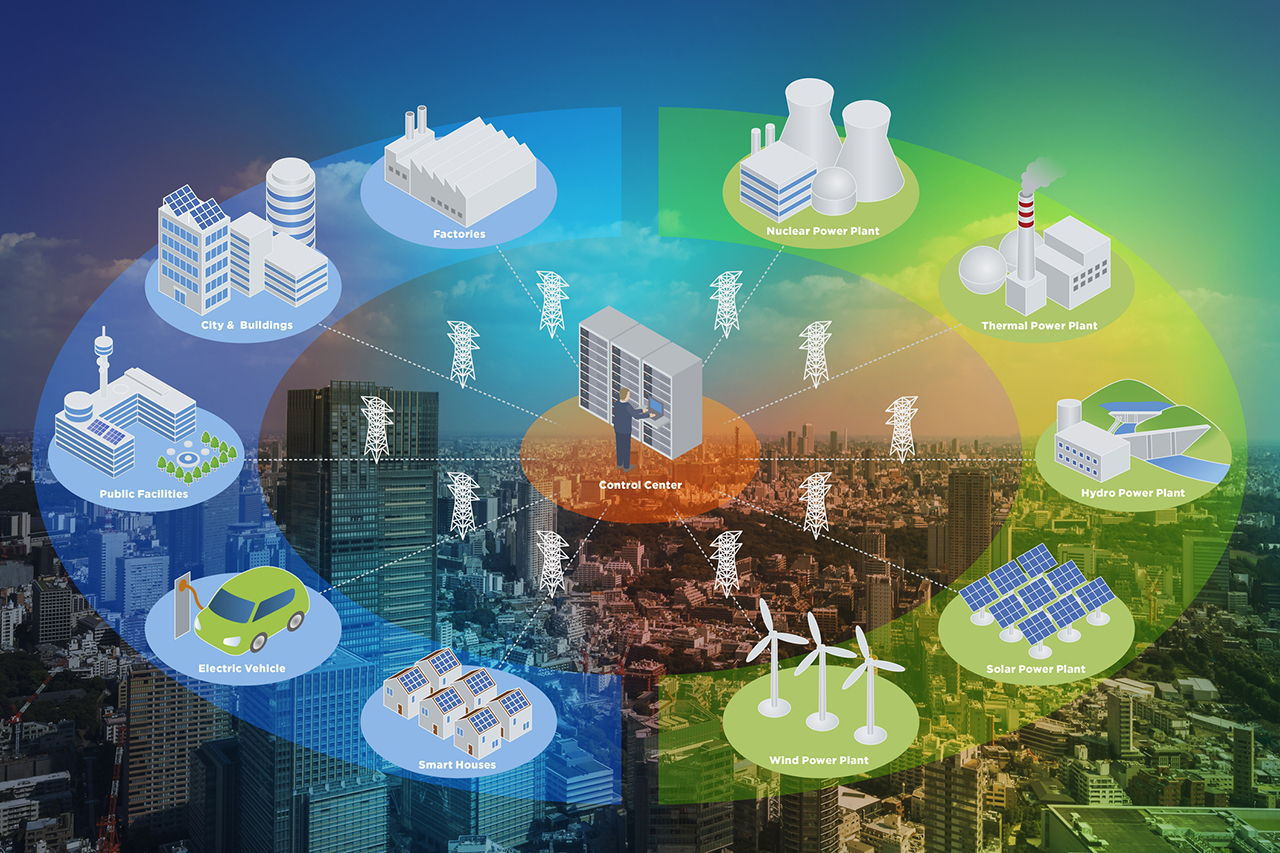

[Source](https://www.digi.com/getattachment/Blog/post/What-Is-the-Smart-Grid-and-How-Is-It-Enabled-by-Io/GettyImages-611997358-1280w.jpg?lang=en-US)

# Smart Grid Stability (Augmented version of the original hosted in the UCI Machine Learning Repository.)
[Click for access to the data](https://www.kaggle.com/datasets/pcbreviglieri/smart-grid-stability)
### About the data

#### 12 predictive attributes, 2 goal fields:
#### tau[x]: reaction time of participant (real from the range [0.5,10]s). Tau1 - the value for electricity producer.
#### p[x]: nominal power consumed(negative)/produced(positive)(real). For consumers from the range [-0.5,-2]s^-2; p1 = abs(p2 + p3 + p4)
#### g[x]: coefficient (gamma) proportional to price elasticity (real from the range [0.05,1]s^-1). g1 - the value for electricity producer.
#### stab: the maximal real part of the characteristic equation root (if positive - the system is linearly unstable)(real)
#### stabf: the stability label of the system (categorical: stable/unstable)

#### Building a model to classify whether a electrical grid is stable or not will enable us to detect malfunctioning grids which can result to massive power loss or accident

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.utils.data import DataLoader,TensorDataset,RandomSampler
from sklearn.linear_model import LogisticRegression

In [158]:
data = pd.read_csv('C:/Users/HP/Downloads/smart_grid_stability_augmented.csv'); data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [159]:
data.shape

(60000, 14)

#### Both, prediction and classification can be practised using this dataset, our motive is classification so we drop the prediction target column.
#### As p1 is clearly a linear function of p2, p3 and p4, we drop it.

In [6]:
data = data.drop(['p1','stab'], axis = 1); data.head(5)

,tau1,tau2,tau3,tau4,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable
2,8.971707,8.848428,3.046479,1.214518,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,unstable
3,0.716415,7.669600,4.486641,2.340563,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,unstable
4,3.134112,7.608772,4.943759,9.857573,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,unstable


## EDA

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='stabf', ylabel='count'>

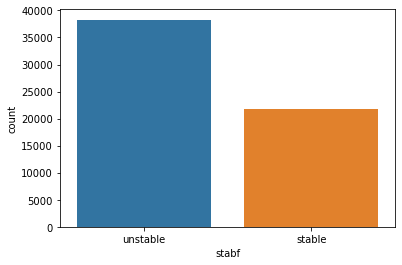

In [7]:
sns.countplot(data['stabf'] )

## Preparing the data

In [9]:

X = data.drop(['stabf'], axis = 1)
y = data['stabf']

In [157]:
data.corr()     ##correlation matrix

,tau1,tau2,tau3,tau4,p2,p3,p4,g1,g2,g3,g4
tau1,1.000000,-0.002550,-0.002550,-0.002550,-0.015739,-0.015739,-0.015739,0.010521,0.006522,0.006522,0.006522
tau2,-0.002550,1.000000,0.005554,0.005554,-0.004473,-0.000372,-0.000372,-0.005832,0.009865,0.002102,0.002102
tau3,-0.002550,0.005554,1.000000,0.005554,-0.000372,-0.004473,-0.000372,-0.005832,0.002102,0.009865,0.002102
tau4,-0.002550,0.005554,0.005554,1.000000,-0.000372,-0.000372,-0.004473,-0.005832,0.002102,0.002102,0.009865
p2,-0.015739,-0.004473,-0.000372,-0.000372,1.000000,0.002833,0.002833,-0.000417,-0.002141,0.000774,0.000774
p3,-0.015739,-0.000372,-0.004473,-0.000372,0.002833,1.000000,0.002833,-0.000417,0.000774,-0.002141,0.000774
p4,-0.015739,-0.000372,-0.000372,-0.004473,0.002833,0.002833,1.000000,-0.000417,0.000774,0.000774,-0.002141
g1,0.010521,-0.005832,-0.005832,-0.005832,-0.000417,-0.000417,-0.000417,1.000000,0.004718,0.004718,0.004718
g2,0.006522,0.009865,0.002102,0.002102,-0.002141,0.000774,0.000774,0.004718,1.000000,-0.006939,-0.006939
g3,0.006522,0.002102,0.009865,0.002102,0.000774,-0.002141,0.000774,0.004718,-0.006939,1.000000,-0.006939


In [10]:
le = LabelEncoder()
y = le.fit_transform(y)

In [11]:
sc = preprocessing.MinMaxScaler()
X = sc.fit_transform(X)

In [12]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.30)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.30                )


In [13]:
print('X training shape:', x_train.shape)
print('Y training shape:', y_train.shape)
print('X validation shape:', x_val.shape)
print('Y validation shape:', y_val.shape)
print('X testing shape:', x_test.shape)
print('Y testing shape:', y_test.shape)


X training shape: (42000, 11)
Y training shape: (42000,)
X validation shape: (12600, 11)
Y validation shape: (12600,)
X testing shape: (5400, 11)
Y testing shape: (5400,)


#### We need to classify the electrical grid into stable (0) and unstable (1) classes.The simple algorithm for binary classification is logistic regression, and we use it to see how accurately we can classify the electric grids  

## Logistic Regression

### Using LBFGS

In [210]:
lor1 = LogisticRegression(penalty = 'none', solver = 'lbfgs', tol = 0.01, max_iter = 200)


In [211]:
pred1 = lor1.fit(x_train, y_train)

In [218]:
print('Using no regulariser and LBFGS solver, we get training accuracy: ',pred1.score(x_train, y_train)*100)

Using no regulariser and LBFGS solver, we get training accuracy:  81.35


In [217]:
print('Using no regulariser and LBFGS solver, we get testing accuracy: ',pred1.score(x_test, y_test)*100)

Using no regulariser and LBFGS solver, we get testing accuracy:  81.61111111111111


In [214]:
lor2 = LogisticRegression(penalty = 'l2', solver = 'lbfgs', tol = 0.01, max_iter = 200)

In [215]:
pred2 = lor2.fit(x_train, y_train)

In [219]:
print('Using l2 regulariser and LBFGS solver, we get training accuracy: ',pred2.score(x_train, y_train)*100)

Using l2 regulariser and LBFGS solver, we get training accuracy:  81.36428571428571


In [220]:
print('Using l2 regulariser and LBFGS solver, we get testing accuracy: ',pred2.score(x_test, y_test)*100)

Using l2 regulariser and LBFGS solver, we get testing accuracy:  81.64814814814815


### Using SAG

In [230]:
lor3 = LogisticRegression(penalty = 'none', solver = 'sag', tol = 0.01, max_iter = 200)

In [231]:
pred3 = lor3.fit(x_train, y_train)

In [235]:
print('Using no regulariser and SAG solver, we get training accuracy: ', pred3.score(x_train, y_train)*100)

Using no regulariser and SAG solver, we get training accuracy:  81.37142857142857


In [236]:
print('Using no regulariser and SAG solver, we get testing accuracy: ', pred3.score(x_test, y_test)*100)

Using no regulariser and SAG solver, we get testing accuracy:  81.64814814814815


In [237]:
lor4 = LogisticRegression(penalty = 'l2', solver = 'sag', tol = 0.01, max_iter = 200)

In [238]:
pred4 = lor4.fit(x_train, y_train)

In [239]:
print('Using l2 regulariser and SAG solver, we get training accuracy: ', pred4.score(x_train, y_train)*100)

Using l2 regulariser and SAG solver, we get training accuracy:  81.34285714285714


In [242]:
print('Using l2 regulariser and SAG solver, we get testing accuracy: ', pred4.score(x_test, y_test)*100)

Using l2 regulariser and SAG solver, we get testing accuracy:  81.51851851851852


### Using SAGA

In [240]:
lor5 = LogisticRegression(penalty = 'none', solver = 'saga', tol = 0.01, max_iter = 200)

In [241]:
pred5 = lor5.fit(x_train, y_train)

In [243]:
print('Using no regulariser and SAGA solver, we get training accuracy: ', pred5.score(x_train, y_train)*100)

Using no regulariser and SAGA solver, we get training accuracy:  81.33571428571429


In [244]:
print('Using no regulariser and SAGA solver, we get testing accuracy: ', pred5.score(x_test, y_test)*100)

Using no regulariser and SAGA solver, we get testing accuracy:  81.53703703703704


In [245]:
lor6 = LogisticRegression(penalty = 'l1', solver = 'saga', tol = 0.01, max_iter = 200)

In [247]:
pred6 = lor6.fit(x_train, y_train)

In [248]:
print('Using l1 regulariser and SAGA solver, we get training accuracy: ', pred6.score(x_train, y_train)*100)

Using l1 regulariser and SAGA solver, we get training accuracy:  81.34285714285714


In [250]:
print('Using l1 regulariser and SAGA solver, we get testing accuracy: ', pred6.score(x_test, y_test)*100)

Using l1 regulariser and SAGA solver, we get testing accuracy:  81.5925925925926


In [251]:
lor7 = LogisticRegression(penalty = 'l2', solver = 'saga', tol = 0.01, max_iter = 200)

In [252]:
pred7 = lor7.fit(x_train, y_train)

In [253]:
print('Using l2 regulariser and SAGA solver, we get training accuracy: ', pred7.score(x_train, y_train)*100)

Using l2 regulariser and SAGA solver, we get training accuracy:  81.36428571428571


In [254]:
print('Using l2 regulariser and SAGA solver, we get testing accuracy: ', pred7.score(x_test, y_test)*100)

Using l2 regulariser and SAGA solver, we get testing accuracy:  81.62962962962963


| Solver | Regulariser | Training Accuracy | Testing Accuracy |
| --- | --- | --- | --- |
| LBFGS | None | 81.35 | 81.611  |
| LBFGS | l2   | 81.364 | 81.648  |
|  SAG  | None | 81.371 | 81.648  |
|  SAG  | l2   | 81.343 | 81.518  |
| SAGA  | None | 81.336 | 81.537  |
| SAGA  | l1   | 81.343 | 81.592  |
| SAGA  | l2   | 81.364 | 81.63  |

#### We can see that the accuracy do not differ significantly when we change the solver or the regulariserand keeping in mind, this is a stimulated dataset, the accuracy to be achieved should be higher.To achieve higher accuracy, we build a neural network model.

## Building the model

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(11,7),
            nn.ReLU(),
            nn.Linear(7,5),
            nn.ReLU(),
            nn.Linear(5,3)
        )
        self.fc = nn.Linear(3,1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.fc(self.linear_relu_stack(x))
        predicts = self.sig(out)
        return predicts
    
loss_func = nn.BCELoss()    ### using binary cross entropy loss function

[Model inspiration from](https://github.com/christianversloot/machine-learning-articles/blob/main/using-relu-sigmoid-and-tanh-with-pytorch-ignite-and-lightning.md)

## Training Validation and Testing

In [15]:
def training(dataloader, model, loss_fn, optimizer):
    training_loss = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X, y
        pred = model(X.float())
        loss = loss_fn(pred.view(X.shape[0]).float(), y.float())
        training_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        grad = 0
    print('Training loss = ', np.sum(training_loss)/len(dataloader))
    return training_loss 

In [16]:
def validation(dataloader, model, loss_fn):
    validation_loss = []
    valid_loss = 0.0
    min_val_loss = np.inf
    model.eval()
    for i, (X, y) in enumerate(dataloader):
        target = model(X.float())
        loss = loss_fn(target.view(X.shape[0]).float(), y.float())
        valid_loss = loss.item()
        validation_loss.append(valid_loss)
    print("\n Validation Loss = ", np.sum(validation_loss)/len(dataloader))
    return np.mean(validation_loss)   

In [17]:
def test(dataloader, model, threshold):
    for i, (data, label) in enumerate(dataloader):
        outputs = (model(data.float())>threshold)
        accuracy = 100*sum(label.detach().numpy()==outputs.detach().numpy().astype(int).squeeze())/x_test.shape[0]
    return accuracy

In [18]:
train_class = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
validation_class = TensorDataset(torch.tensor(x_val), torch.tensor(y_val))
test_class = TensorDataset(torch.tensor(x_test), torch.tensor(y_test))

# GD

In [144]:
train_dataloader = DataLoader(train_class, batch_size = x_train.shape[0])
valid_dataloader = DataLoader(validation_class, batch_size = x_val.shape[0])
test_dataloader = DataLoader(test_class, batch_size = x_test.shape[0])

In [145]:
model = NeuralNetwork()

In [146]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [147]:
epochs = 3000
train_losses = []
valid_losses = []
for i in range(epochs):
    print(f" Epoch number: {i+1}\n-----------")
    train_loss_print = training(train_dataloader, model, loss_func, optimizer)
    valid_loss_print = validation(valid_dataloader, model, loss_func)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    valid_losses.append(valid_loss_print)
    

 Epoch number: 1
-----------
Training loss =  0.6545789241790771

 Validation Loss =  0.6544695496559143
 Epoch number: 2
-----------
Training loss =  0.6545770764350891

 Validation Loss =  0.6544678807258606
 Epoch number: 3
-----------
Training loss =  0.6545754075050354

 Validation Loss =  0.6544660925865173
 Epoch number: 4
-----------
Training loss =  0.6545736789703369

 Validation Loss =  0.6544643640518188
 Epoch number: 5
-----------
Training loss =  0.6545719504356384

 Validation Loss =  0.6544625759124756
 Epoch number: 6
-----------
Training loss =  0.6545702219009399

 Validation Loss =  0.6544607281684875
 Epoch number: 7
-----------
Training loss =  0.6545685529708862

 Validation Loss =  0.6544589996337891
 Epoch number: 8
-----------
Training loss =  0.654566764831543

 Validation Loss =  0.6544573903083801
 Epoch number: 9
-----------
Training loss =  0.6545650362968445

 Validation Loss =  0.6544556617736816
 Epoch number: 10
-----------
Training loss =  0.6545633

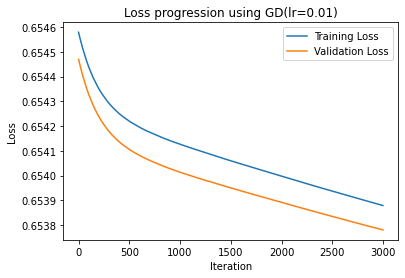

In [148]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title("Loss progression using GD(lr=0.01)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [149]:
acc=[]
for i in np.linspace(0.1,1,50):
    acc.append(test(test_dataloader,model,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

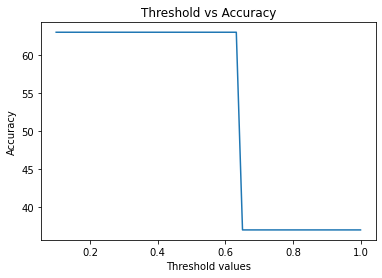

In [150]:
plt.plot(np.linspace(0.1,1,50),acc)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [151]:
print("The best accuracy we can achieve using GD with constant LR: ",acc[np.argmax(acc)])

The best accuracy we can achieve using GD with constant LR:  62.98148148148148


In [153]:
print('The optimum threshold is: ', np.linspace(0.1, 1, 50)[np.argmax(acc)])

The optimum threshold is:  0.1


#### The loss function decreases very slowly in gradient descent, even after 3000 epoch the loss is very high, to overcome this problem, we should use stochastic gradient descent for minimising the loss
### The accuracy is very poor.

# SGD

In [28]:
model1 = NeuralNetwork()

In [29]:
train_dataloader = DataLoader(train_class, batch_size = 1, sampler = RandomSampler(x_train))
valid_dataloader = DataLoader(validation_class, batch_size = x_val.shape[0])
test_dataloader = DataLoader(test_class, batch_size = x_test.shape[0])

In [30]:
optimizer1 = torch.optim.SGD(model1.parameters(), lr = 0.01)

In [31]:
epochs = 200
train_losses = []
valid_losses = []
for i in range(epochs):
    print(f" Epoch number: {i+1}\n-----------")
    train_loss_print  = training(train_dataloader, model1, loss_func, optimizer1)
    valid_loss_print = validation(valid_dataloader, model1, loss_func)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    valid_losses.append(valid_loss_print)
    

 Epoch number: 1
-----------
Training loss =  0.4160660654526519

 Validation Loss =  0.26711127161979675
 Epoch number: 2
-----------
Training loss =  0.238301387731735

 Validation Loss =  0.22371532022953033
 Epoch number: 3
-----------
Training loss =  0.20753862276671922

 Validation Loss =  0.2360866516828537
 Epoch number: 4
-----------
Training loss =  0.19393565004789684

 Validation Loss =  0.20742464065551758
 Epoch number: 5
-----------
Training loss =  0.18755741693758793

 Validation Loss =  0.269217312335968
 Epoch number: 6
-----------
Training loss =  0.18364065437075577

 Validation Loss =  0.1690286546945572
 Epoch number: 7
-----------
Training loss =  0.18056349238588643

 Validation Loss =  0.168502077460289
 Epoch number: 8
-----------
Training loss =  0.17730216874821886

 Validation Loss =  0.2901759445667267
 Epoch number: 9
-----------
Training loss =  0.17566414596014243

 Validation Loss =  0.17212344706058502
 Epoch number: 10
-----------
Training loss =  

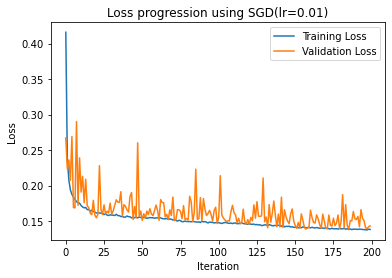

In [32]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title("Loss progression using SGD(lr=0.01)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [33]:
acc1=[]
for i in np.linspace(0.1,1,50):
    acc1.append(test(test_dataloader,model1,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

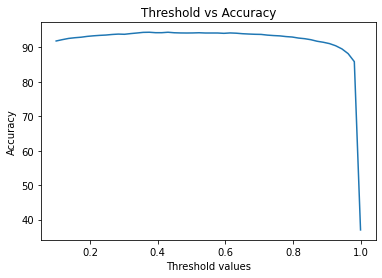

In [34]:
plt.plot(np.linspace(0.1,1,50),acc1)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [35]:
print("The best accuracy we can achieve using SGD with constant LR: ",acc1[np.argmax(acc1)])

The best accuracy we can achieve using SGD with constant LR:  94.42592592592592


In [36]:
print('The optimum threshold is: ', np.linspace(0.1, 1, 50)[np.argmax(acc1)])

The optimum threshold is:  0.3755102040816327


#### The loss function decreases rapidly in stochastic gradient descent, but the fluctuation in validation loss is very high, though the trend is decreasing. As the gradient is calculated by selection a random loss, it is uncertain the loss decreasesin every step, but the overall trend is decreasing
### The accuracy improved massively

# SGD (minibatching)

#### Minibatch Size = 64

In [37]:
model2 = NeuralNetwork()

In [38]:
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01)

In [39]:
train_dataloader = DataLoader(train_class, batch_size=64, sampler = RandomSampler(x_train))
valid_dataloader = DataLoader(validation_class, batch_size=x_val.shape[0])
test_dataloader = DataLoader(test_class, batch_size=x_test.shape[0])


In [40]:
epochs = 200
train_losses = []
valid_losses = []
for i in range(epochs):
    print(f" Epoch number: {i+1}\n-----------")
    train_loss_print  = training(train_dataloader, model2, loss_func, optimizer2)
    valid_loss_print = validation(valid_dataloader, model2, loss_func)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    valid_losses.append(valid_loss_print)
    

 Epoch number: 1
-----------
Training loss =  0.6547211287047039

 Validation Loss =  0.6530371904373169
 Epoch number: 2
-----------
Training loss =  0.6527597842514061

 Validation Loss =  0.6523014903068542
 Epoch number: 3
-----------
Training loss =  0.6519962020297755

 Validation Loss =  0.6512416005134583
 Epoch number: 4
-----------
Training loss =  0.6507658684453282

 Validation Loss =  0.649431049823761
 Epoch number: 5
-----------
Training loss =  0.6480903795139249

 Validation Loss =  0.6458720564842224
 Epoch number: 6
-----------
Training loss =  0.6428536197547681

 Validation Loss =  0.6378232836723328
 Epoch number: 7
-----------
Training loss =  0.6301038317847288

 Validation Loss =  0.6179698705673218
 Epoch number: 8
-----------
Training loss =  0.5959686788431223

 Validation Loss =  0.5630491375923157
 Epoch number: 9
-----------
Training loss =  0.5170288834397652

 Validation Loss =  0.46762314438819885
 Epoch number: 10
-----------
Training loss =  0.435692

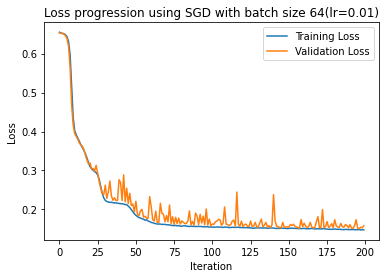

In [41]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title("Loss progression using SGD with batch size 64(lr=0.01)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [42]:
acc2=[]
for i in np.linspace(0.1,1,50):
    acc2.append(test(test_dataloader,model2,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

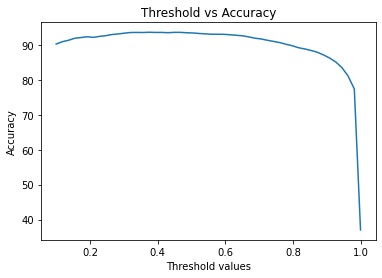

In [43]:
plt.plot(np.linspace(0.1,1,50),acc2)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [44]:
print("The best accuracy we can achieve using SGD with batch size 64 (constant LR): ",acc2[np.argmax(acc2)])

The best accuracy we can achieve using SGD with batch size 64 (constant LR):  93.64814814814815


In [45]:
print('The optimum threshold is: ', np.linspace(0.1, 1, 50)[np.argmax(acc2)])

The optimum threshold is:  0.3755102040816327


#### Using SGD with minibatch of size 64, improves the fluctuations in validation loss, the accuracy is decreased

#### Minibatch Size = 32

In [46]:
model3 = NeuralNetwork()

In [47]:
optimizer3 = torch.optim.SGD(model3.parameters(), lr=0.01)

In [48]:
train_dataloader = DataLoader(train_class, batch_size=32, sampler = RandomSampler(x_train))
valid_dataloader = DataLoader(validation_class, batch_size=x_val.shape[0])
test_dataloader = DataLoader(test_class, batch_size=x_test.shape[0])


In [49]:
epochs = 200
train_losses = []
valid_losses = []
for i in range(epochs):
    print(f" Epoch number: {i+1}\n-----------")
    train_loss_print= training(train_dataloader, model3, loss_func, optimizer3)
    valid_loss_print = validation(valid_dataloader, model3, loss_func)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    valid_losses.append(valid_loss_print)
    

 Epoch number: 1
-----------
Training loss =  0.6556454615246133

 Validation Loss =  0.6510621905326843
 Epoch number: 2
-----------
Training loss =  0.6490910329259449

 Validation Loss =  0.6460106372833252
 Epoch number: 3
-----------
Training loss =  0.6381920246749276

 Validation Loss =  0.6247833967208862
 Epoch number: 4
-----------
Training loss =  0.5824615841409403

 Validation Loss =  0.5152274966239929
 Epoch number: 5
-----------
Training loss =  0.43251721033229235

 Validation Loss =  0.3817346692085266
 Epoch number: 6
-----------
Training loss =  0.3606199899522385

 Validation Loss =  0.33973428606987
 Epoch number: 7
-----------
Training loss =  0.32163457331295153

 Validation Loss =  0.30770501494407654
 Epoch number: 8
-----------
Training loss =  0.2929674170951033

 Validation Loss =  0.2830028831958771
 Epoch number: 9
-----------
Training loss =  0.2579842374999834

 Validation Loss =  0.24342387914657593
 Epoch number: 10
-----------
Training loss =  0.2309

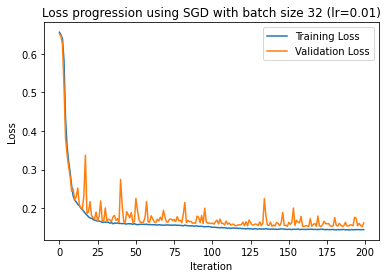

In [50]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title("Loss progression using SGD with batch size 32 (lr=0.01)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [51]:
acc3=[]
for i in np.linspace(0.1,1,50):
    acc3.append(test(test_dataloader,model3,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

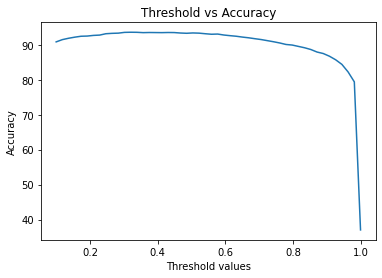

In [52]:
plt.plot(np.linspace(0.1,1,50),acc3)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [53]:
print("The best accuracy we can achieve using SGD with batch size 32 (constant LR): ",acc3[np.argmax(acc3)])

The best accuracy we can achieve using SGD with batch size 32 (constant LR):  93.61111111111111


In [54]:
print('The optimum threshold is: ', np.linspace(0.1, 1, 50)[np.argmax(acc3)])

The optimum threshold is:  0.3204081632653062


#### Using SGD with minibatch of size 32, improves the fluctuations in validation loss comapring to that of size 1 but is worse than batch size 64, the accuracy is decreased a little

# SGD (momentum)

In [55]:
model4 = NeuralNetwork()

In [56]:
optimizer4 = torch.optim.SGD(model4.parameters(), lr=0.01, momentum = 0.9)

In [57]:
train_dataloader = DataLoader(train_class, batch_size=1, sampler = RandomSampler(x_train))
valid_dataloader = DataLoader(validation_class, batch_size=x_val.shape[0])
test_dataloader = DataLoader(test_class, batch_size=x_test.shape[0])

In [58]:
epochs = 60
train_losses = []
valid_losses = []
for i in range(epochs):
    print(f" Epoch number: {i+1}\n-----------")
    train_loss_print  = training(train_dataloader, model4, loss_func, optimizer4)
    valid_loss_print = validation(valid_dataloader, model4, loss_func)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    valid_losses.append(valid_loss_print)
    

 Epoch number: 1
-----------
Training loss =  0.4773523683677254

 Validation Loss =  0.5931700468063354
 Epoch number: 2
-----------
Training loss =  0.3419149694802831

 Validation Loss =  0.2754480242729187
 Epoch number: 3
-----------
Training loss =  0.32884345753013383

 Validation Loss =  0.40496671199798584
 Epoch number: 4
-----------
Training loss =  0.32635068020173186

 Validation Loss =  0.33830228447914124
 Epoch number: 5
-----------
Training loss =  0.3177628945025309

 Validation Loss =  0.3224724233150482
 Epoch number: 6
-----------
Training loss =  0.3345345288347579

 Validation Loss =  0.32480573654174805
 Epoch number: 7
-----------
Training loss =  0.3203197747129717

 Validation Loss =  0.28858277201652527
 Epoch number: 8
-----------
Training loss =  0.323435529487656

 Validation Loss =  0.37066176533699036
 Epoch number: 9
-----------
Training loss =  0.32380860153873786

 Validation Loss =  0.32158997654914856
 Epoch number: 10
-----------
Training loss =  

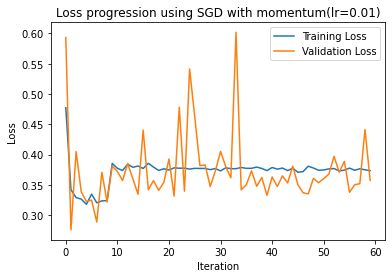

In [59]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title("Loss progression using SGD with momentum(lr=0.01)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [60]:
acc4=[]
for i in np.linspace(0.1,1,50):
    acc4.append(test(test_dataloader,model4,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

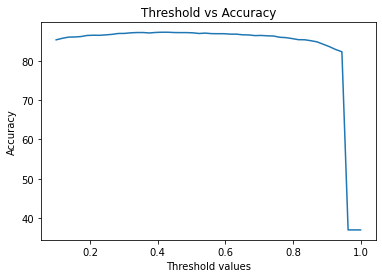

In [61]:
plt.plot(np.linspace(0.1,1,50),acc4)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [62]:
print("The best accuracy we can achieve using SGD with momentum (constant LR): ",acc4[np.argmax(acc4)])

The best accuracy we can achieve using SGD with momentum (constant LR):  87.24074074074075


In [63]:
print('The optimum threshold is: ', np.linspace(0.1, 1, 50)[np.argmax(acc4)])

The optimum threshold is:  0.41224489795918373


#### SGD with momentum fluctuates the validation loss massively and the training loss is not decreasing, resulting in poor performance than the previous SGD models

# Adagrad

In [64]:
model5 = NeuralNetwork()

In [65]:
train_dataloader = DataLoader(train_class, batch_size=64, sampler = RandomSampler(x_train))
valid_dataloader = DataLoader(validation_class, batch_size=x_val.shape[0])
test_dataloader = DataLoader(test_class, batch_size=x_test.shape[0])

In [66]:
optimizer5 = torch.optim.Adagrad(model5.parameters(), lr = 0.01)

In [67]:
epochs = 200
train_losses = []
valid_losses = []
for i in range(epochs):
    print(f" Epoch number: {i+1}\n-----------")
    train_loss_print = training(train_dataloader, model5, loss_func, optimizer5)
    valid_loss_print = validation(valid_dataloader, model5, loss_func)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    valid_losses.append(valid_loss_print)
    

 Epoch number: 1
-----------
Training loss =  0.5386317926636207

 Validation Loss =  0.4525492191314697
 Epoch number: 2
-----------
Training loss =  0.4182090622740068

 Validation Loss =  0.39205092191696167
 Epoch number: 3
-----------
Training loss =  0.3796838842888038

 Validation Loss =  0.36928433179855347
 Epoch number: 4
-----------
Training loss =  0.3656589394517504

 Validation Loss =  0.360793799161911
 Epoch number: 5
-----------
Training loss =  0.3588908944772259

 Validation Loss =  0.35492444038391113
 Epoch number: 6
-----------
Training loss =  0.35298335477369563

 Validation Loss =  0.34994277358055115
 Epoch number: 7
-----------
Training loss =  0.3478884905168455

 Validation Loss =  0.3454599678516388
 Epoch number: 8
-----------
Training loss =  0.3435739385392205

 Validation Loss =  0.34186065196990967
 Epoch number: 9
-----------
Training loss =  0.339303766869156

 Validation Loss =  0.3383393883705139
 Epoch number: 10
-----------
Training loss =  0.33

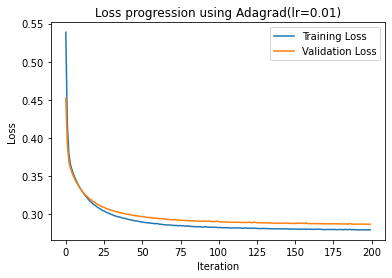

In [68]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title("Loss progression using Adagrad(lr=0.01)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [69]:
acc5=[]
for i in np.linspace(0.1,1,50):
    acc5.append(test(test_dataloader,model5,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

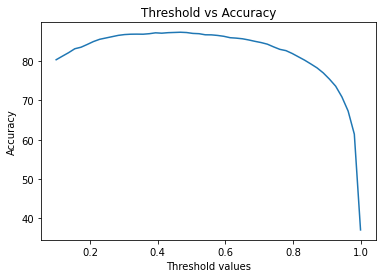

In [70]:
plt.plot(np.linspace(0.1,1,50),acc5)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [71]:
print("The best accuracy we can achieve using Adagrad with constant LR: ",acc5[np.argmax(acc5)])

The best accuracy we can achieve using Adagrad with constant LR:  87.35185185185185


In [72]:
print('The optimum threshold is: ', np.linspace(0.1, 1, 50)[np.argmax(acc5)])

The optimum threshold is:  0.46734693877551026


#### Adagrad minimizes both, validation and training losses rapidly and smoothly and the accuracy is better than SGD with momentum

# RMSProp

In [73]:
model6 = NeuralNetwork()

In [74]:
optimizer6 = torch.optim.RMSprop(model6.parameters(), lr = 0.01)

In [75]:
train_dataloader = DataLoader(train_class, batch_size=64, sampler = RandomSampler(x_train))
valid_dataloader = DataLoader(validation_class, batch_size=x_val.shape[0])
test_dataloader = DataLoader(test_class, batch_size=x_test.shape[0])

In [76]:
epochs = 250
train_losses = []
valid_losses = []
for i in range(epochs):
    print(f" Epoch number: {i+1}\n-----------")
    train_loss_print  = training(train_dataloader, model6, loss_func, optimizer6)
    valid_loss_print = validation(valid_dataloader, model6, loss_func)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    valid_losses.append(valid_loss_print)
    

 Epoch number: 1
-----------
Training loss =  0.3582890611850689

 Validation Loss =  0.3063103258609772
 Epoch number: 2
-----------
Training loss =  0.2815309138784307

 Validation Loss =  0.2660363018512726
 Epoch number: 3
-----------
Training loss =  0.25527757927888783

 Validation Loss =  0.2463211864233017
 Epoch number: 4
-----------
Training loss =  0.2486248419165067

 Validation Loss =  0.23973894119262695
 Epoch number: 5
-----------
Training loss =  0.24465326182374128

 Validation Loss =  0.2642962634563446
 Epoch number: 6
-----------
Training loss =  0.2418577970435086

 Validation Loss =  0.29010504484176636
 Epoch number: 7
-----------
Training loss =  0.2380782936329711

 Validation Loss =  0.3030649721622467
 Epoch number: 8
-----------
Training loss =  0.23706843167588773

 Validation Loss =  0.25722432136535645
 Epoch number: 9
-----------
Training loss =  0.23379100503079606

 Validation Loss =  0.24776995182037354
 Epoch number: 10
-----------
Training loss =  

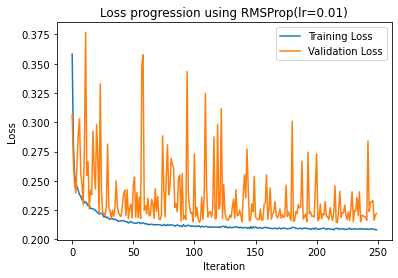

In [77]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title("Loss progression using RMSProp(lr=0.01)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [78]:
acc6=[]
for i in np.linspace(0.1,1,50):
    acc6.append(test(test_dataloader,model6,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

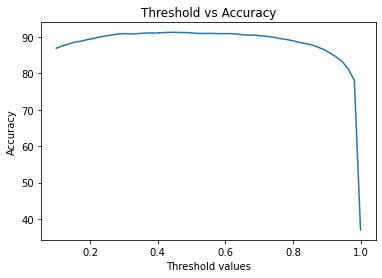

In [79]:
plt.plot(np.linspace(0.1,1,50),acc6)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [80]:
print("The best accuracy we can achieve using RMSProp with constant LR: ",acc6[np.argmax(acc6)])

The best accuracy we can achieve using RMSProp with constant LR:  91.27777777777777


In [81]:
print('The optimum threshold is: ', np.linspace(0.1, 1, 50)[np.argmax(acc6)])

The optimum threshold is:  0.44897959183673475


#### The loss in training fluctuatues little while decreasing but the validation loss is very much unstable, but the model performs significantly better 

# Adam

In [82]:
model7 = NeuralNetwork()

In [83]:
optimizer7 = torch.optim.Adam(model7.parameters(), lr = 0.01)

In [84]:
train_dataloader = DataLoader(train_class, batch_size=64, sampler = RandomSampler(x_train))
valid_dataloader = DataLoader(validation_class, batch_size=x_val.shape[0])
test_dataloader = DataLoader(test_class, batch_size=x_test.shape[0])

In [85]:
epochs = 250
train_losses = []
valid_losses = []
for i in range(epochs):
    print(f" Epoch number: {i+1}\n-----------")
    train_loss_print  = training(train_dataloader, model7, loss_func, optimizer7)
    valid_loss_print = validation(valid_dataloader, model7, loss_func)
    train_losses.append(sum(train_loss_print)/len(train_loss_print))
    valid_losses.append(valid_loss_print)
    

 Epoch number: 1
-----------
Training loss =  0.41129072294024754

 Validation Loss =  0.37523379921913147
 Epoch number: 2
-----------
Training loss =  0.35387932410523226

 Validation Loss =  0.3530767261981964
 Epoch number: 3
-----------
Training loss =  0.34872151840948806

 Validation Loss =  0.35010504722595215
 Epoch number: 4
-----------
Training loss =  0.34770748078188035

 Validation Loss =  0.3521217703819275
 Epoch number: 5
-----------
Training loss =  0.34713712504737454

 Validation Loss =  0.35437601804733276
 Epoch number: 6
-----------
Training loss =  0.3478946047331826

 Validation Loss =  0.34835976362228394
 Epoch number: 7
-----------
Training loss =  0.3475953938618098

 Validation Loss =  0.34768903255462646
 Epoch number: 8
-----------
Training loss =  0.3459585795981336

 Validation Loss =  0.36000147461891174
 Epoch number: 9
-----------
Training loss =  0.3462373387278306

 Validation Loss =  0.3437683582305908
 Epoch number: 10
-----------
Training loss 

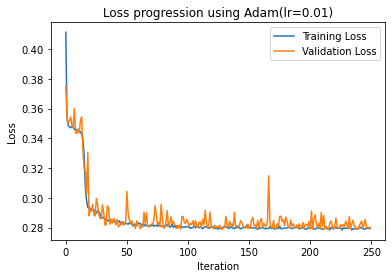

In [86]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title("Loss progression using Adam(lr=0.01)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])

In [87]:
acc7=[]
for i in np.linspace(0.1,1,50):
    acc7.append(test(test_dataloader,model7,i))

Text(0.5, 1.0, 'Threshold vs Accuracy')

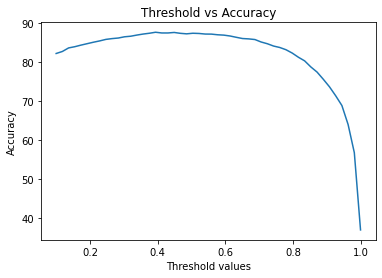

In [88]:
plt.plot(np.linspace(0.1,1,50),acc7)
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.title("Threshold vs Accuracy")

In [89]:
print("The best accuracy we can achieve using Adam with constant LR: ",acc7[np.argmax(acc7)])

The best accuracy we can achieve using Adam with constant LR:  87.66666666666667


In [261]:
print('The optimum threshold is: ', np.linspace(0.1, 1, 50)[np.argmax(acc7)])

The optimum threshold is:  0.3938775510204082


#### The training loss fluctuates negligible but the validation loss is fluctuatinga lot, the model performs better than the one using Adagrad as optimizer, but is not as good as RMSProp. 

| Model | Optimizer | Testing Accuracy |
| --- | --- | --- |
| model | GD | 62.8  |
| model1 | SGD   | 94.43 |
|  model2  | SGD(minibatch size 64) | 93.65 |
|  model3  | SGD(minibatch size 32)   | 93.61 |
| model4  | SGD(momentum) | 87.24 | 
| model5  | Adagrad   | 87.35 | 
| model6  | RMSProp   | 91.27 | 
| model7 | Adam | 87.66 |

#### So we can see that using neural networks resulted in better classification except when we minimize the loss using gradient descent, the best performing model is model1 that it SGD with batch size 1, then the minibatch size 64 and 32 respectivly, followed by model6 which is using RMSProp for minimizing the loss.